# ML Workflow

The objective of this exercise is to use the tools and methods that you learned during the previous weeks, in order to solve a **real challenge**.

The problem to solve is a **Kaggle Competition**: [New York City Taxi Fare Prediction](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction). The goal is to predict the fare amount (inclusive of tolls) for a taxi ride in New York City given the pickup and dropoff locations.

Building a machine learning model requires a few different steps.

## Steps
1. Get the data
2. Explore the data
3. Data cleaning
4. Evaluation metric
5. Model baseline
6. Build your first model
7. Model evaluation
8. Kaggle submission
9. Model iteration

## 1. Get the data <a id='part1'></a>

The dataset is available on [Kaggle](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data).

First of all:
- Follow the instructions to download the training and test sets
- Put the datasets in a separate folder on your local disk. You can name it "data" for example.

Now we are going to use Pandas to read and explore the datasets.

In [1]:
import pandas as pd

The training dataset is relatively big (~5GB).
So let's only open a portion of it.
👉 Go to [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/) to see how to open a portion of CSV file and store it into a DataFrame (ex: just read 1 million rows maximum)

💡 NB: here we will read portion of a file **directly from a URL**, the same can be done with local file

⚠️ Make sure that you have installed the `s3fs` package.

In [2]:
%%time
url = 's3://wagon-public-datasets/taxi-fare-train.csv'
df = pd.read_csv(url, nrows=1_000_000)

CPU times: user 5.35 s, sys: 1.18 s, total: 6.53 s
Wall time: 20.1 s


Now let's display the first rows to understand the different fields 

In [3]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## 2. Explore the data <a id='part2'></a>

Before trying to solve the prediction problem, we need to get a better understanding of the data.
In order to do that, we are going to use libraries such as Pandas and Seaborn.
First of all, make sure you have [Seaborn](https://seaborn.pydata.org/) installed and import it into your notebook.
Note that it can also be useful to import `matplotlib.pyplot` in order to customize a few things.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 14
plt.figure(figsize=(12,5))
palette = sns.color_palette('Paired', 10)

<Figure size 864x360 with 0 Axes>

### There are multiple things we want to do in terms of data exploration

- You first want to look at the distribution of the variable that you are going to predict: "fare_amount"
- Then you want to visualize other variable distributions
- And finally it is often very helpful to compute and visualize the correlation between the target variable and other variables
- Also, lets look for any missing values, or other irregularities

### Explore the target variable
- Compute simple statistics for the target variable (min, max, mean, std, etc)
- Plot distributions

In [5]:
df.fare_amount.describe()

count    1000000.000000
mean          11.348079
std            9.822090
min          -44.900000
25%            6.000000
50%            8.500000
75%           12.500000
max          500.000000
Name: fare_amount, dtype: float64

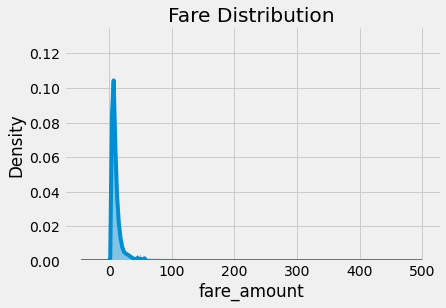

In [6]:
def plot_dist(series=df["fare_amount"], title="Fare Distribution"):
    sns.histplot(series, kde=True, stat='density', discrete=True)
    sns.despine()
    plt.title(title);
    plt.show()
plot_dist()

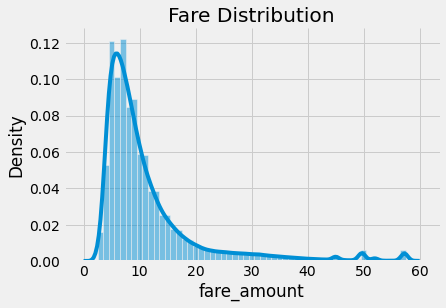

In [24]:
# drop absurd values 
df = df[df.fare_amount.between(0, 60)]
plot_dist(df.fare_amount)

In [8]:
import numpy as np 

# we can also visualize binned fare_amount variable
df['fare-bin'] = pd.cut(df['fare_amount'], 
                        bins = list(range(0, 50, 5)), 
                        include_lowest=True).astype('str')

# uppermost bin
df['fare-bin'] = df['fare-bin'].replace(np.nan, '[45+]')
# df.loc[df['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# apply this to clean up the label of the first bin
df['fare-bin'] = df['fare-bin'].apply(lambda x: x.replace('-0.001', '0'))

# sort by fare the correct look in the chart
df = df.sort_values(by='fare_amount')

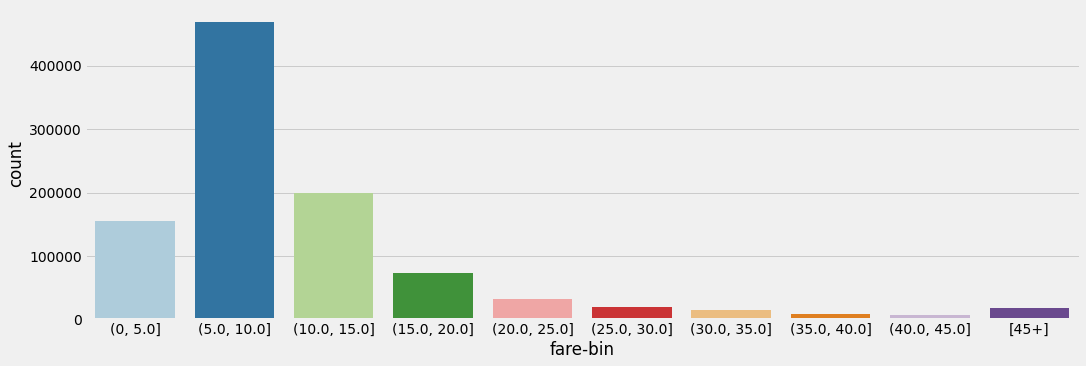

In [9]:
sns.catplot(x="fare-bin", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.show()

### Explore other variables

- passenger_count (statistics + distribution)
- pickup_datetime (you need to build time features out of the pickup datetime)
- Geospatial features (pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude)
- Find other variables that you can compute from existing data and that might explain the target

#### Passenger Count

In [10]:
df.passenger_count.describe()

count    997297.000000
mean          1.685096
std           1.324201
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

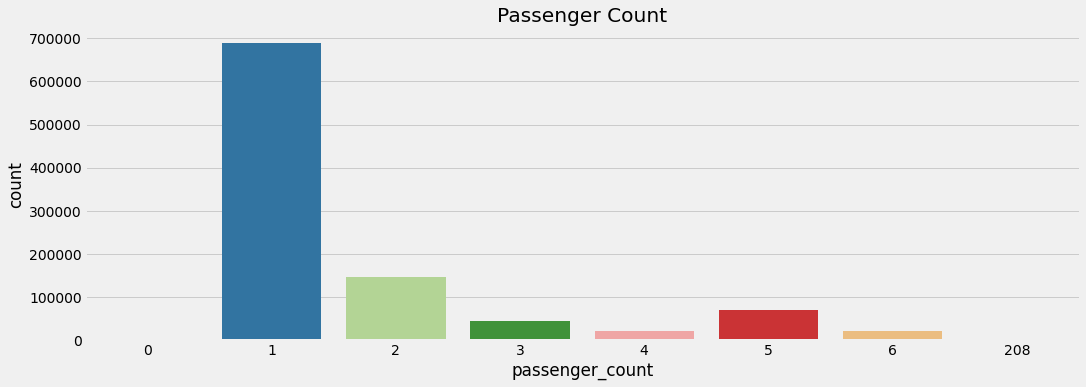

In [11]:
sns.catplot(x="passenger_count", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Passenger Count');
plt.show()

#### Pickup Datetime

- Extract time features from pickup_datetime (hour, day of week, month, year)
- Create a method `def extract_time_features(_df)` that you will be able to re-use later
- Be careful with the timezone
- Explore the newly created features 

In [12]:
def extract_time_features(df):
    timezone_name = 'America/New_York'
    time_column = "pickup_datetime"
    df.index = pd.to_datetime(df[time_column])
    df.index = df.index.tz_convert(timezone_name)
    df["dow"] = df.index.weekday
    df["hour"] = df.index.hour
    df["month"] = df.index.month
    df["year"] = df.index.year
    return df.reset_index(drop=True)

In [13]:
%%time
df = extract_time_features(df)

CPU times: user 2min 50s, sys: 2.14 s, total: 2min 52s
Wall time: 3min 22s


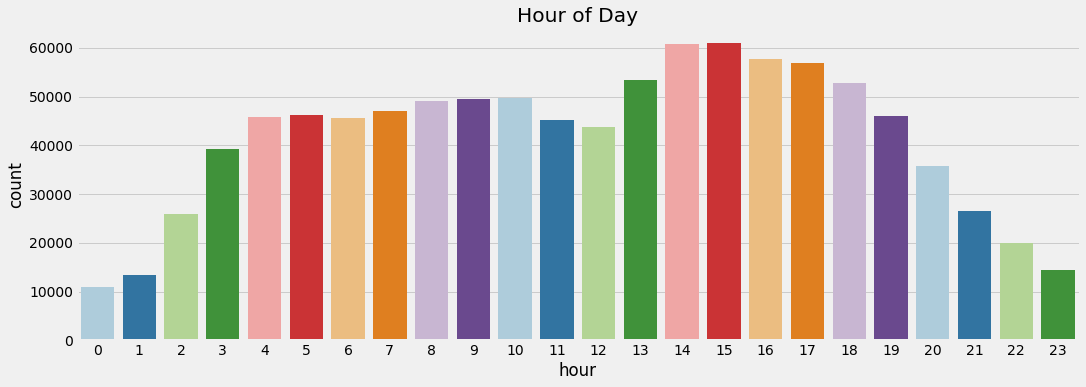

In [14]:
# hour of day
sns.catplot(x="hour", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Hour of Day');
plt.show()

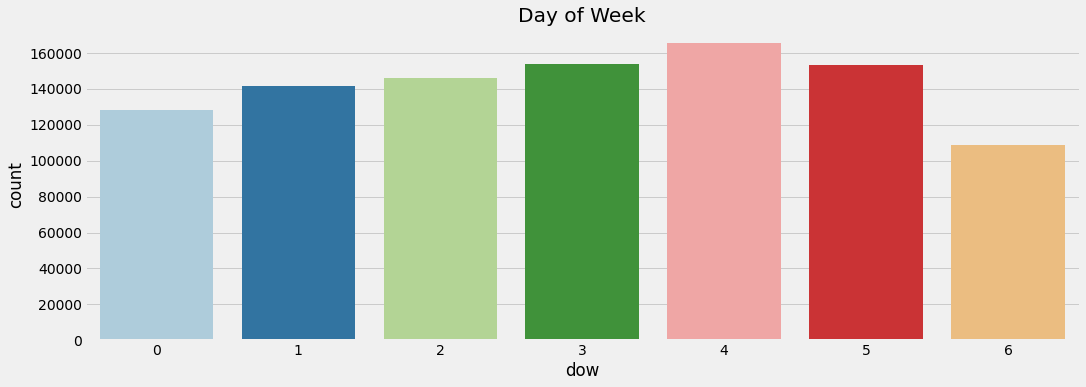

In [15]:
# day of week
sns.catplot(x="dow", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.title('Day of Week');
plt.show()

#### Add timezone features

- Extract time features from pickup_datetime (hour, day of week, month, year)
- Create a method `def extract_time_features(_df)` that you will be able to re-use later
- Be careful of timezone
- Explore the newly created features

In [16]:
df_test = pd.read_csv("./data/test.csv")

In [19]:
# find the boudaries from the test set and remove the outliers from the training set
for col in ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]:
    MIN = df_test[col].min()
    MAX = df_test[col].max()
    print(col, MIN, MAX)

pickup_latitude 40.573143 41.709555
pickup_longitude -74.252193 -72.986532
dropoff_latitude 40.568973 41.696683
dropoff_longitude -74.263242 -72.990963


In [20]:
df = df[df["pickup_latitude"].between(left = 40, right = 42 )]
df = df[df["pickup_longitude"].between(left = -74.3, right = -72.9 )]
df = df[df["dropoff_latitude"].between(left = 40, right = 42 )]
df = df[df["dropoff_longitude"].between(left = -74, right = -72.9 )]

In [21]:
# make sure that you install folium first
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

In [22]:
center_location = [40.758896, -73.985130]
m = folium.Map(location=center_location, control_scale=True, zoom_start=11)

In [23]:
df["count"] =1
heatmap_data = df.head(10000)[['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
HeatMap(data=heatmap_data, radius=5, gradient=gradient, max_zoom=13).add_to(m)
m

In [25]:
heatmap_data_by_hour = []
__df__ = df.head(10000)
for hour in df.hour.sort_values().unique():
    _df = __df__[__df__.hour == hour][['pickup_latitude', 'pickup_longitude', 'count']].groupby(['pickup_latitude', 'pickup_longitude']).sum().reset_index().values.tolist()
    heatmap_data_by_hour.append(_df)

In [26]:
m2 = folium.Map(location=center_location, control_scale=True, zoom_start=11)
HeatMapWithTime(heatmap_data_by_hour, radius=5,
                gradient=gradient,
                min_opacity=0.5, max_opacity=0.8,
                use_local_extrema=False).add_to(m2)
m2

#### Distance

- Compute the distance between pickup and dropoff locations (tip: https://en.wikipedia.org/wiki/Haversine_formula)
- Write a method `def haversine_distance(df, **kwargs)` that you will be able to reuse later
- Compute a few statistics for distance and plot distance distribution

In [27]:
import numpy as np
def haversine_distance(df,
                       start_lat="start_lat",
                       start_lon="start_lon",
                       end_lat="end_lat",
                       end_lon="end_lon"):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Vectorized version of the haversine distance for pandas df
    Computes distance in kms
    """

    lat_1_rad, lon_1_rad = np.radians(df[start_lat].astype(float)), np.radians(df[start_lon].astype(float))
    lat_2_rad, lon_2_rad = np.radians(df[end_lat].astype(float)), np.radians(df[end_lon].astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6371 * c
    return haversine_distance

df["distance"] = haversine_distance(df, 
                                    start_lat="pickup_latitude", start_lon="pickup_longitude",
                                    end_lat="dropoff_latitude", end_lon="dropoff_longitude")

In [28]:
df.distance.describe()

count    847916.000000
mean          3.288393
std           3.717411
min           0.000000
25%           1.236222
50%           2.112549
75%           3.837169
max         104.254968
Name: distance, dtype: float64

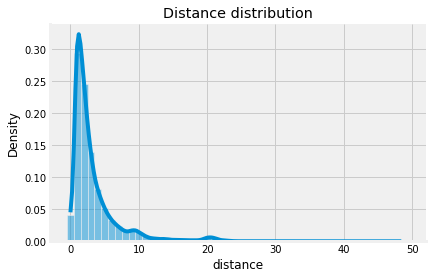

In [29]:
%matplotlib inline
plot_dist(series=df[df.distance < 50].distance, title='Distance distribution')

#### Explore how target variable correlate with other variables

- As a first step, you can visualize the target variable vs another variable. For categorical variables, it is often useful to compute the average target variable for each category (Seaborn has plots that do it for you!). For continuous variables (like distance, you can use scatter plots, or regression plots, or bucket the distance into different bins
- But there many different ways to visualize correlation between features, so be creative

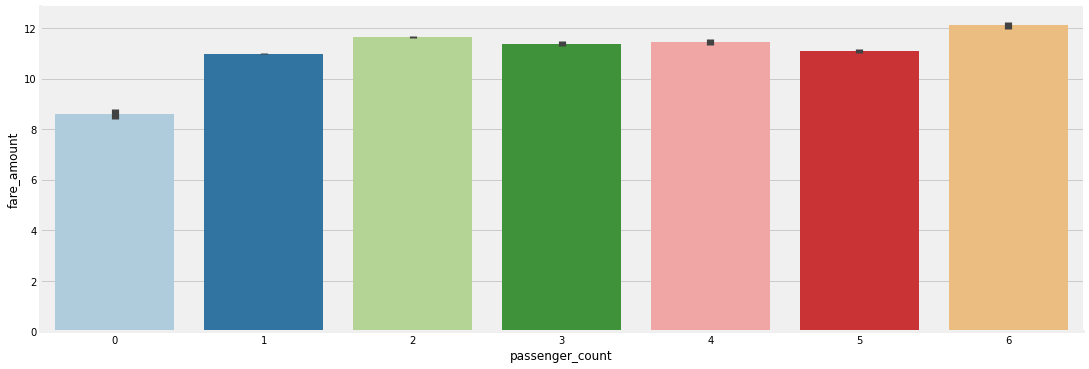

In [30]:
sns.catplot(x="passenger_count", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

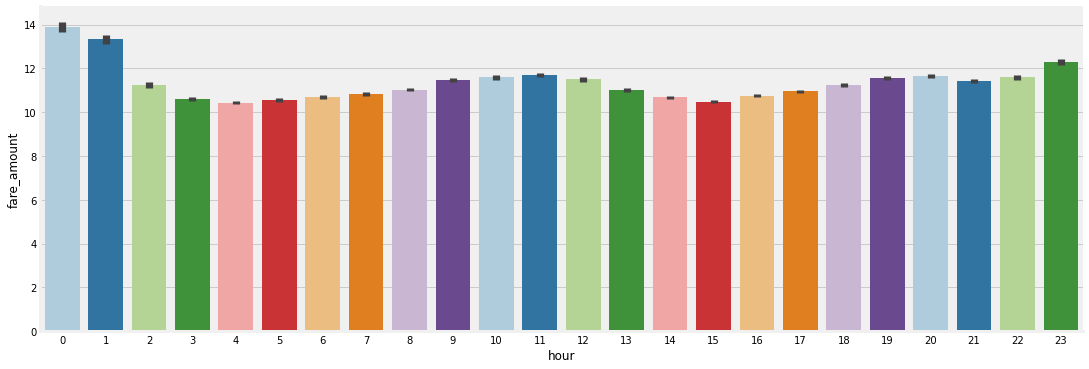

In [31]:
sns.catplot(x="hour", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

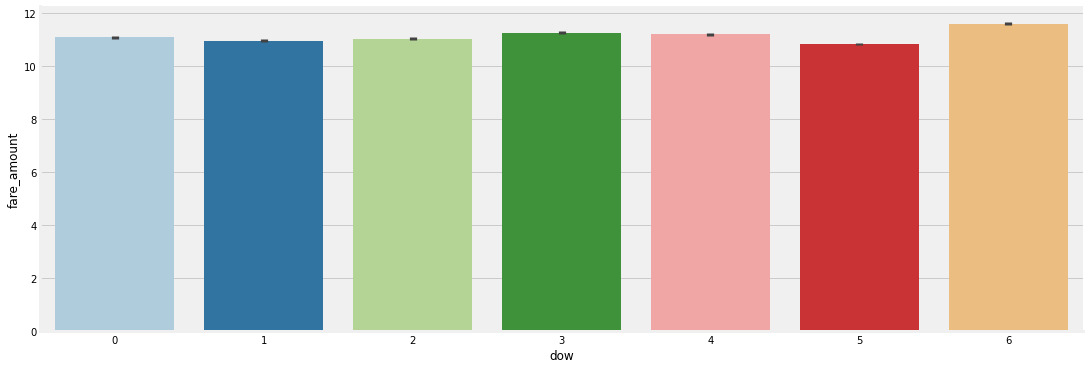

In [32]:
sns.catplot(x="dow", y="fare_amount", palette=palette, data=df, kind="bar", aspect=3)
sns.despine()
plt.show()

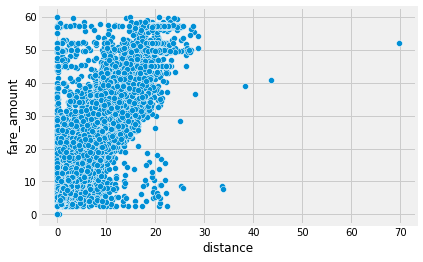

In [33]:
sns.scatterplot(x="distance", y="fare_amount", data=df[df.distance < 80].sample(100000))
plt.show()

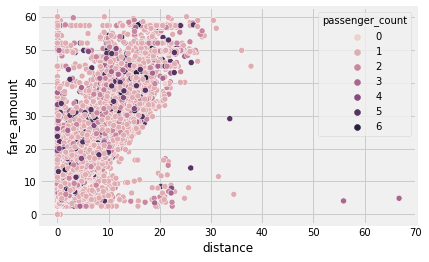

In [34]:
sns.scatterplot(x="distance", y="fare_amount", hue="passenger_count", data=df[df.distance < 80].sample(100000))
plt.show()

## 3. Data cleaning <a id='part3'></a>

As you probably saw in the previous section during your data exploration, there are some values that do not seem valid.
In this section, you will take a few steps to clean the training data.

Remove all the trips that look incorrect. We recommend that you write a method called `clean_data(df)` that you will be able to re-use in the next steps.

In [35]:
print("trips with negative fares:", len(df[df.fare_amount <= 0]))
print("trips with too high distance:", len(df[df.distance >= 100]))
print("trips with too many passengers:", len(df[df.passenger_count > 8]))
print("trips with zero passenger:", len(df[df.passenger_count == 0]))

trips with negative fares: 18
trips with too high distance: 16
trips with too many passengers: 0
trips with zero passenger: 2999


In [37]:
def clean_data(df, test=False):
    df = df.dropna(how='any', axis='rows')
    df = df[(df.dropoff_latitude != 0) | (df.dropoff_longitude != 0)]
    df = df[(df.pickup_latitude != 0) | (df.pickup_longitude != 0)]
    df = df[df.fare_amount.between(0, 4000)]
    df = df[df.passenger_count < 8]
    df = df[df.passenger_count >= 0]
    df = df[df["pickup_latitude"].between(40, 42)]
    df = df[df["pickup_longitude"].between(-74.3, -72.9 )]
    df = df[df["dropoff_latitude"].between(40, 42)]
    df = df[df["dropoff_longitude"].between(-74, -72.9)]
    return df

df_cleaned = clean_data(df)
"% data removed", (1 - len(df_cleaned) / len(df)) * 100

('% data removed', 0.0)

In [38]:
df_cleaned.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'fare-bin', 'dow', 'hour', 'month', 'year', 'count',
       'distance'],
      dtype='object')

## 4. Evaluation metric <a id='part4'></a>

The evaluation metric for this competition is the root mean-squared error or RMSE. The RMSE measures the difference between the predictions of a model, and the corresponding ground truth. A large RMSE is equivalent to a large average error, so smaller values of RMSE are better.

More details here https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation

Write a method `def compute_rmse(y_pred, y_true)` that computes the RMSE given `y_pred` and `y_true` which are two numpy arrays corresponding to model predictions and ground truth values.

This method will be useful in order to evaluate the performance of your model.

In [39]:
def compute_rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true)**2).mean())

## 5. Model baseline <a id='part5'></a>

Before building your model, it is often useful to get a performance benchmark. For this, you will use a baseline model that is a very dumb model and compute the evaluation metric on that model.
Then, you will be able to see how much better your model is compared to the baseline. It is very common to see ML teams coming up with very sophisticated approaches without knowing by how much their model beats the very simple model.

- Generate predictions based on a simple heuristic
- Evaluate the RMSE for these predictions

In [40]:
df['y_pred'] = df_cleaned['fare_amount'].mean()

compute_rmse(df['y_pred'], df['fare_amount'])

8.989136548959618

## 6. Build your first model <a id='part6'></a>

Now it is time to build your model!

For starters we are going to use a linear model only. We will try more sophisticated models later.

Here are the different steps that you have to follow:

1. Split the data into two different sets (training and validation). You will be measuring the performance of your model on the validation set
2. Make sure that you apply the data cleaning on your training set
3. Think about the different features you want to add in your model
4. For each of these features, make sure you apply the correct transformation so that the model can correctly learn from them (this is true for categorical variables like `hour of day` or `day of week`)
5. Train your model

##### Training/Validation Split

In [41]:
# training/validation
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.1)

##### Apply data cleaning on training set

In [42]:
df_train = clean_data(df_train)

##### List features (continuous vs categorical)

In [43]:
# features
target = "fare_amount"
features = ["distance", "hour", "dow", "passenger_count"]
categorical_features = ["hour", "dow", "passenger_count"]

In [44]:
df_train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,dow,hour,month,year,count,distance,y_pred
778114,2014-08-26 13:09:22.0000001,13.5,2014-08-26 13:09:22 UTC,-73.976190,40.751537,-73.998904,40.720206,1,"(10.0, 15.0]",1,9,8,2014,1,3.974888,11.136315
753915,2011-09-27 13:13:00.000000168,12.9,2011-09-27 13:13:00 UTC,-73.984463,40.774623,-73.971472,40.756132,5,"(10.0, 15.0]",1,9,9,2011,1,2.329070,11.136315
417188,2014-08-30 19:08:19.0000001,7.5,2014-08-30 19:08:19 UTC,-73.972702,40.763312,-73.989902,40.761962,1,"(5.0, 10.0]",5,15,8,2014,1,1.456365,11.136315
216277,2009-05-31 13:11:00.000000170,5.7,2009-05-31 13:11:00 UTC,-73.982915,40.757903,-73.977308,40.766405,1,"(5.0, 10.0]",6,9,5,2009,1,1.056762,11.136315
54363,2012-05-10 01:30:27.0000001,4.1,2012-05-10 01:30:27 UTC,-73.992360,40.731345,-73.988564,40.732107,1,"(0, 5.0]",2,21,5,2012,1,0.330885,11.136315


##### Features transformation

- Write a method `def transform_features(df, **kwargs)` because you will have to make sure that you apply the same transformations on the validation (or test set) before making predictions
- For categorical features transformation, you can use `pandas.get_dummies` method

In [45]:
def transform_features(_df, dummy_features=None):
    encode = True if dummy_features is None else False
    dummy_features = dummy_features if dummy_features is not None else []
    for c in categorical_features:
        dummies = pd.get_dummies(_df[c], prefix=c)
        _df = pd.concat([_df, dummies], axis=1)
        if encode:
            dummy_features = dummy_features + (list(dummies.columns.values))
    for dummy_feature in [f for f in dummy_features if f not in _df.columns]:
        _df[dummy_feature] = 0 
    _df = _df[dummy_features + features]
    return _df, dummy_features

##### Model training

In [46]:
# model training
from sklearn.linear_model import LassoCV
model = LassoCV(cv=5, n_alphas=5)
X_train, dummy_features = transform_features(df_train)
X_train = df_train[features]
y_train = df_train.fare_amount
model.fit(X_train, y_train)

LassoCV(cv=5, n_alphas=5)

## 7. Model evaluation <a id='part7'></a>

Now in order to evaluate your model, you need to use your previously trained model in order to make predictions on the validation set.

For this, follow these steps:
1. Apply the same transformations on the validation set
2. Make predictions
3. Evaluate predictions using `compute_rmse` method

In [47]:
# X_val, _ = transform_features(df_val, dummy_features=dummy_features)
X_test = df_test[features]
df_test["y_pred"] = model.predict(X_test)
compute_rmse(df_test.y_pred, df_test.fare_amount)

<ipython-input-47-117bfe1d391c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["y_pred"] = model.predict(X_test)


4.543429160704266

## 8. Kaggle submission <a id='part8'></a>

Now that you have a model, you can now make predictions on Kaggle test set and be evaluated by Kaggle directly.

- Download the test data from Kaggle
- Follow the [instructions](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview/evaluation) to make sure that your predictions are in the right format
- Re-train your model using all the data (do not split with train/validation)
- Apply the feature engineering and transformation methods on the test set
- Use the model to make predictions on the test set
- Submit your predictions!

In [48]:
# Re-train the model with all the data
df_cleaned = clean_data(df)
X = df_cleaned[features]
y = df_cleaned.fare_amount

from sklearn.linear_model import Lasso

lasso = Lasso(alpha=5)
lasso.fit(X,y)

Lasso(alpha=5)

In [49]:
# load Kaggle's test set
df_test = pd.read_csv("./data/test.csv")
df_test.head(1)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.97332,40.763805,-73.98143,40.743835,1


In [50]:
# feature engineering
df_test["distance"] = haversine_distance(df_test, 
                                         start_lat="pickup_latitude", start_lon="pickup_longitude",
                                         end_lat="dropoff_latitude", end_lon="pickup_longitude")
df_test = extract_time_features(df_test)
# X_test, _ = transform_features(df_test, dummy_features=dummy_features) 
X_test = df_test[features]

# prediction
df_test["y_pred"] = lasso.predict(X_test)

In [51]:
df_test.head(1)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,dow,hour,month,year,y_pred
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.97332,40.763805,-73.98143,40.743835,1,2.220556,1,8,1,2015,9.329551


In [52]:
df_test.reset_index(drop=True)[["key", "y_pred"]].rename(columns={"y_pred": "fare_amount"}).to_csv("lasso_v0_predictions.csv", index=False)

## 9. [OPTIONAL] Push further Feature Engineering <a id='part9'></a>

You can improve your model by trying different things (But do not worry, some of these things will be covered during the next days).
- Use more data to train
- Build and add more features
- Try different estimators
- Adjust your data cleaning to remove more or less data
- Tune the hyperparameters of your model

In the following section we will focus on advanced feature engineering (keep in mind that relevant feateng is often key to significant increase in model performances):

👉 **Manhattan distance** better suited to our problem  
👉 **Distance to NYC center** to highlight interesting pattern...
👉 **Direction**

###### Another Distance ?
- Think about the distance you used, try and find a more adapted distance for our problem (ask TAs for insights)

$$D(A,B) = \left( \sum_{i=1}^{n} \lvert x_{A_i} - x_{B_i} \rvert ^p \right)^\frac{1}{p}$$
with $A=(x_{A_1}, x_{A_2}, ..., x_{A_n})$ and $B=(x_{B_1}, x_{B_2}, ..., x_{B_n})$

In [53]:
# the Minkowski Distance is actually the generic distance to compute different distances

# in a cartesion system of reference of 2 dimensions (x,y), the Minkowski distance can be implemented as follow:
def minkowski_distance(x1, x2, y1, y2, p):
    delta_x = x1 - x2
    delta_y = y1 - y2
    return ((abs(delta_x) ** p) + (abs(delta_y)) ** p) ** (1 / p)

In [54]:
# in a GPS coordinates system, the Minkowksi distance should be implented as follows:
# convert degrees to radians
def deg2rad(coordinate):
    return coordinate * np.pi / 180

# convert radians into distance
def rad2dist(coordinate):
    earth_radius = 6371 # km
    return earth_radius * coordinate

# correct the longitude distance regarding the latitude (https://jonisalonen.com/2014/computing-distance-between-coordinates-can-be-simple-and-fast/)
def lng_dist_corrected(lng_dist, lat):
    return lng_dist * np.cos(lat)

def minkowski_distance_gps(lat1, lat2, lon1, lon2, p):
    lat1, lat2, lon1, lon2 = [deg2rad(coordinate) for coordinate in [lat1, lat2, lon1, lon2]]
    y1, y2, x1, x2 = [rad2dist(angle) for angle in [lat1, lat2, lon1, lon2]]
    x1, x2 = [lng_dist_corrected(elt['x'], elt['lat']) for elt in [{'x': x1, 'lat': lat1}, {'x': x2, 'lat': lat2}]]
    return minkowski_distance(x1, x2, y1, y2, p)

In [55]:
# manhattan distance <=> minkowski_distance(x1, x2, y1, y2, 1)
df['manhattan_dist'] = minkowski_distance_gps(df['pickup_latitude'], df['dropoff_latitude'],
                                              df['pickup_longitude'], df['dropoff_longitude'], 1)

In [56]:
# euclidian distance <=> minkowski_distance(x1, x2, y1, y2, 2)
df['euclidian_dist'] = minkowski_distance_gps(df['pickup_latitude'], df['dropoff_latitude'],
                                              df['pickup_longitude'], df['dropoff_longitude'], 2)

In [57]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,dow,hour,month,year,count,distance,y_pred,manhattan_dist,euclidian_dist
0,2015-04-15 14:02:39.0000003,0.0,2015-04-15 14:02:39 UTC,-73.937378,40.758450,-73.937447,40.758450,1,"(0, 5.0]",2,10,4,2015,1,0.005783,11.136315,0.005783,0.005783
2,2010-02-20 09:51:27.0000004,0.0,2010-02-20 09:51:27 UTC,-73.877376,40.772415,-73.877403,40.772391,1,"(0, 5.0]",5,4,2,2010,1,0.003506,11.136315,0.007189,0.005250
3,2015-05-27 23:10:03.0000004,0.0,2015-05-27 23:10:03 UTC,-73.994125,40.741131,-73.994125,40.741131,1,"(0, 5.0]",2,19,5,2015,1,0.000000,11.136315,0.000000,0.000000
4,2013-08-05 06:45:54.0000005,0.0,2013-08-05 06:45:54 UTC,-73.982354,40.679971,-73.982354,40.679971,1,"(0, 5.0]",0,2,8,2013,1,0.000000,11.136315,0.000000,0.000000
5,2015-05-26 12:28:03.0000003,0.0,2015-05-26 12:28:03 UTC,-73.986473,40.721909,-73.986473,40.721905,1,"(0, 5.0]",1,8,5,2015,1,0.000424,11.136315,0.000782,0.000555


###### Distance from the center 

- Compute a new feature calculating the distance of pickup location from the center
- Scatter Plot *distance_from_center* regarding *distance* 
- What do you observe ? What new features could you add ? How are these new features correlated to the target ?

In [58]:
# let's compute the distance from the NYC center
nyc_center = (40.7141667, -74.0063889)
df["nyc_lat"], df["nyc_lng"] = nyc_center[0], nyc_center[1]
args =  dict(start_lat="nyc_lat", start_lon="nyc_lng",
             end_lat="pickup_latitude", end_lon="pickup_longitude")

df['distance_to_center'] = haversine_distance(df, **args)

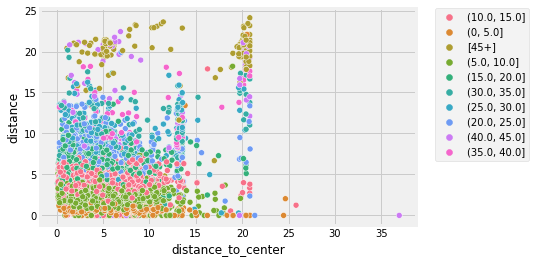

In [59]:
idx = (df.distance < 40) & (df.distance_to_center < 40)
sns.scatterplot(x="distance_to_center", y="distance", data=df[idx].sample(10000), hue="fare-bin")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

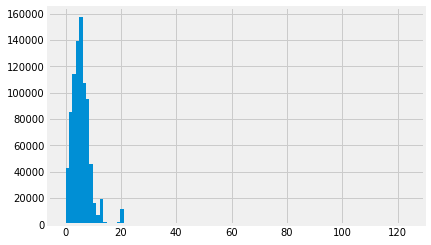

In [61]:
df.distance_to_center.hist(bins=100);

👉 **Take some time to step back and try to observe an interesting pattern here. What are these clusters with a similar distance to the center?**

In [62]:
# seems to be fixed distance_to_center
jfk_center = (40.6441666667, -73.7822222222)

df["jfk_lat"], df["jfk_lng"] = jfk_center[0], jfk_center[1]
args_pickup =  dict(start_lat="jfk_lat", start_lon="jfk_lng",
                    end_lat="pickup_latitude", end_lon="pickup_longitude")
args_dropoff =  dict(start_lat="jfk_lat", start_lon="jfk_lng",
                     end_lat="dropoff_latitude", end_lon="dropoff_longitude")

jfk = (-73.7822222222, 40.6441666667)
df['pickup_distance_to_jfk'] = haversine_distance(df, **args_pickup)
df['dropoff_distance_to_jfk'] = haversine_distance(df, **args_dropoff)

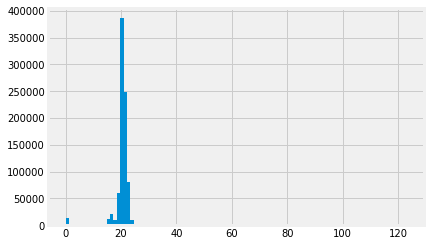

In [63]:
df.pickup_distance_to_jfk.hist(bins=100);

###### Which direction  are you heading to ?

- Compute a new feature calculating the direction your are heading to
- What do you observe ? What new features could you add ? How are these new features correlated to the target ?

In [64]:
def calculate_direction(d_lon, d_lat):
    result = np.zeros(len(d_lon))
    l = np.sqrt(d_lon**2 + d_lat**2)
    result[d_lon>0] = (180/np.pi)*np.arcsin(d_lat[d_lon>0]/l[d_lon>0])
    idx = (d_lon<0) & (d_lat>0)
    result[idx] = 180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    idx = (d_lon<0) & (d_lat<0)
    result[idx] = -180 - (180/np.pi)*np.arcsin(d_lat[idx]/l[idx])
    return result

In [65]:
df['delta_lon'] = df.pickup_longitude - df.dropoff_longitude
df['delta_lat'] = df.pickup_latitude - df.dropoff_latitude
df['direction'] = calculate_direction(df.delta_lon, df.delta_lat)

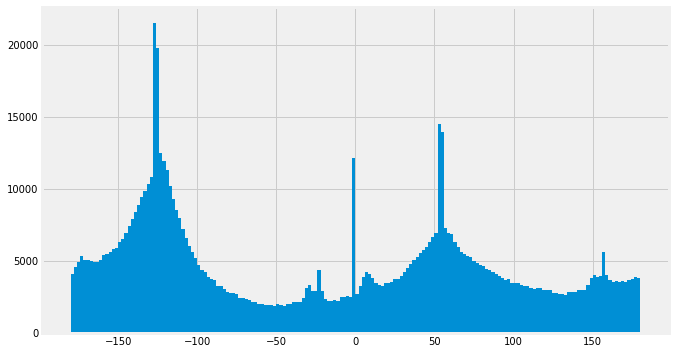

In [66]:
plt.figure(figsize=(10,6))
df.direction.hist(bins=180);

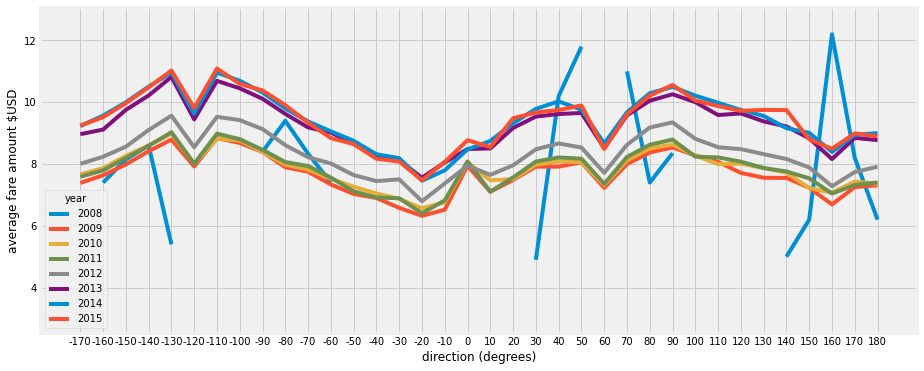

In [67]:
# plot direction vs average fare amount for fares inside manhattan
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
BB_manhattan = (-74.025, -73.925, 40.7, 40.8)
idx_manhattan = select_within_boundingbox(df, BB_manhattan)

fig, ax = plt.subplots(1, 1, figsize=(14,6))
direc = pd.cut(df[idx_manhattan]['direction'], np.linspace(-180, 180, 37))
df[idx_manhattan].pivot_table('fare_amount', index=[direc], columns='year', aggfunc='mean').plot(ax=ax)
plt.xlabel('direction (degrees)')
plt.xticks(range(36), np.arange(-170, 190, 10))
plt.ylabel('average fare amount $USD');

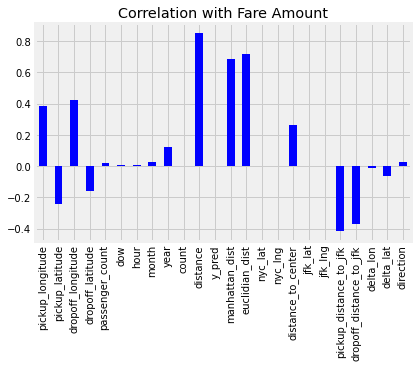

In [68]:
corrs = df.corr()
l = list(corrs)
l.remove("fare_amount")
corrs['fare_amount'][l].plot.bar(color = 'b');
plt.title('Correlation with Fare Amount');